In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 9
commitnumber = d62b618
conc = None
dv = 0.001
klin = 2e-20
molecule = o3
ng_adju = [0, 0]
ng_refs = [2, 5]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (50, 250)]
tsfc = 300
vmax = 3000
vmin = 1900
w_diffuse = [(1.55, 1.55), (1.55, 1.55, 1.55, 1.55, 1.8)]
wgt = [(0.3, 0.4), (0.5, 0.6, 0.7, 0.85, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

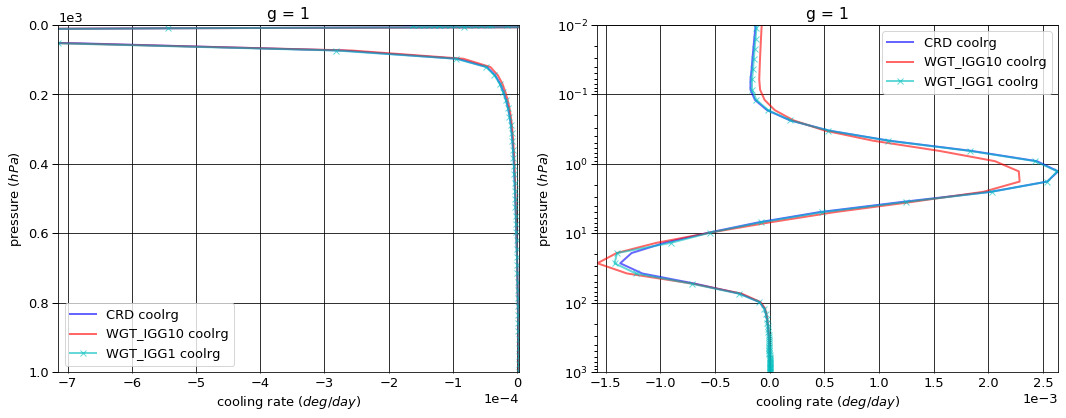

# Figure: cooling rate g-group 2

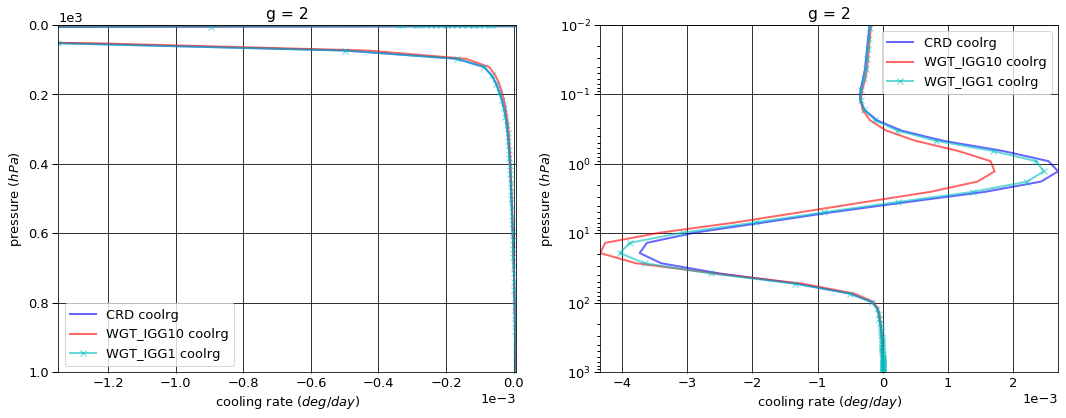

# Figure: cooling rate g-group 3

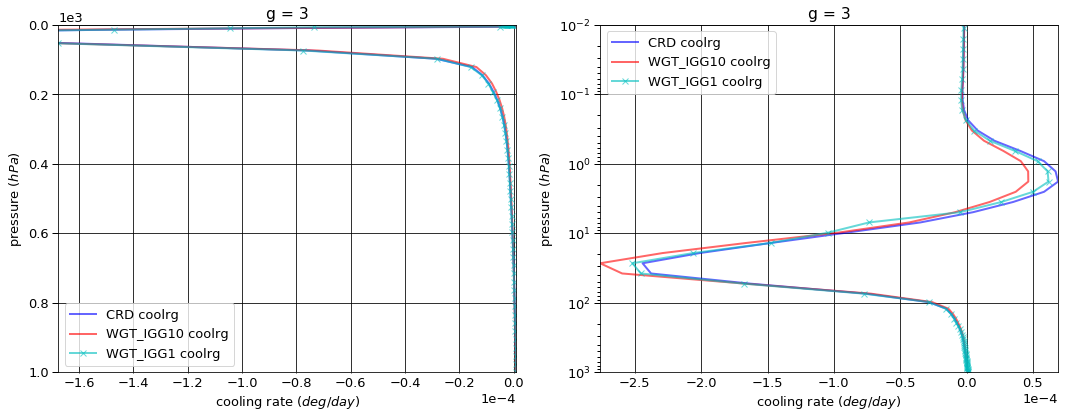

# Figure: cooling rate g-group 4

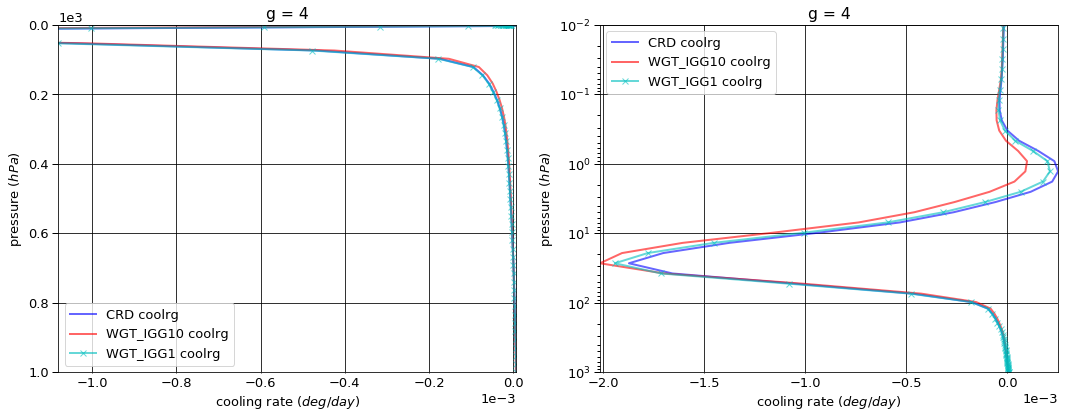

# Figure: cooling rate g-group 5

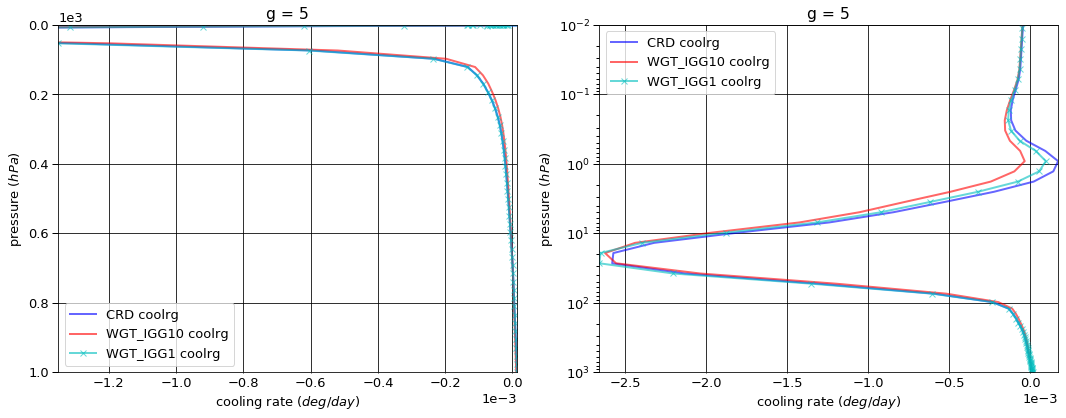

# Figure: cooling rate g-group 6

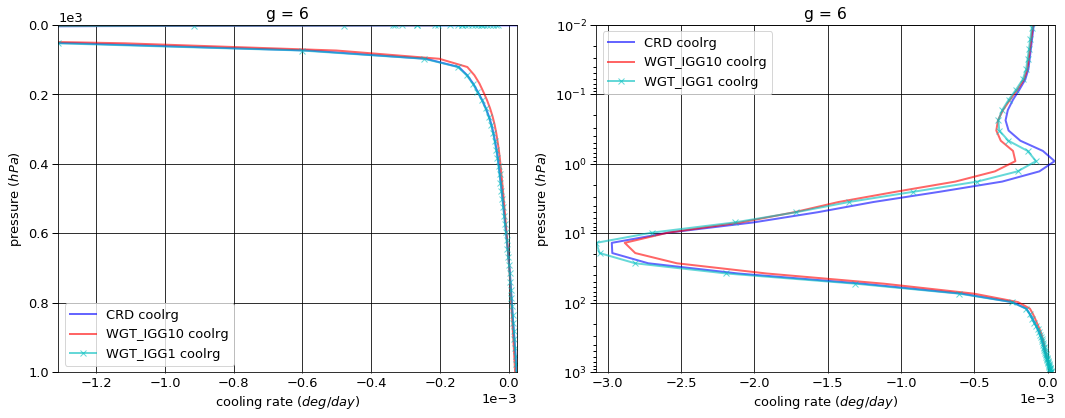

# Figure: cooling rate g-group 7

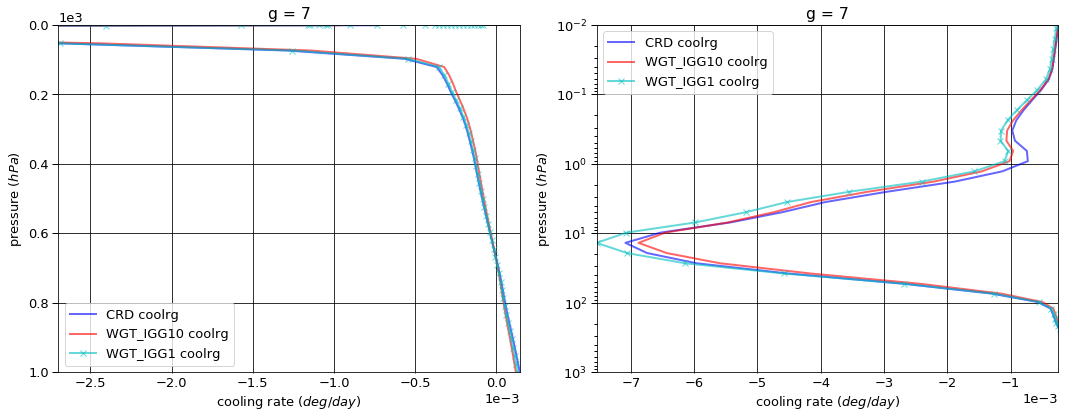

# Figure: cooling rate g-group total

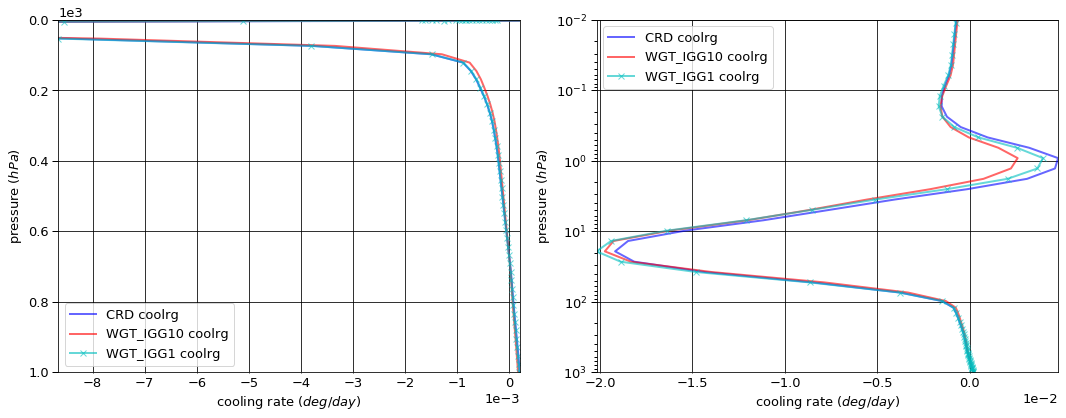

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001326  0.000000 -0.001326
  1013.0   76    -0.008809  0.000396 -0.008413
2 0.0      1     -0.008974  0.000000 -0.008974
  1013.0   76    -0.029407  0.001244 -0.028162
3 0.0      1     -0.000558  0.000000 -0.000558
  1013.0   76    -0.002380  0.000105 -0.002275
4 0.0      1     -0.009777  0.000000 -0.009777
  1013.0   76    -0.022966  0.000792 -0.022174
5 0.0      1     -0.032747  0.000000 -0.032747
  1013.0   76    -0.051711  0.001372 -0.050339
6 0.0      1     -0.075041  0.000000 -0.075041
  1013.0   76    -0.096572  0.001975 -0.094596
7 0.0      1     -7.918020  0.000000 -7.918020
  1013.0   76    -7.973295  0.008890 -7.964405


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001148  0.000000 -0.001148
  1013.0   76    -0.009072  0.000367 -0.008705
2 0.0      1     -0.008505  0.000000 -0.008505
  1013.0   76    -0.030381  0.001232 -0.029149
3 0.0      1     -0.000550  0.000000 -0.000550
  1013.0   76    -0.002444  0.000096 -0.002348
4 0.0      1     -0.010224  0.000000 -0.010224
  1013.0   76    -0.023656  0.000728 -0.022928
5 0.0      1     -0.035282  0.000000 -0.035282
  1013.0   76    -0.053387  0.001198 -0.052189
6 0.0      1     -0.080278  0.000000 -0.080278
  1013.0   76    -0.099940  0.001672 -0.098268
7 0.0      1     -7.915352  0.000000 -7.915352
  1013.0   76    -7.966259  0.007520 -7.958739


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001274  0.000000 -0.001274
  1013.0   76    -0.009072  0.000397 -0.008675
2 0.0      1     -0.008811  0.000000 -0.008811
  1013.0   76    -0.030381  0.001263 -0.029118
3 0.0      1     -0.000552  0.000000 -0.000552
  1013.0   76    -0.002444  0.000108 -0.002336
4 0.0      1     -0.009978  0.000000 -0.009978
  1013.0   76    -0.023656  0.000803 -0.022853
5 0.0      1     -0.033853  0.000000 -0.033853
  1013.0   76    -0.053387  0.001376 -0.052010
6 0.0      1     -0.077644  0.000000 -0.077644
  1013.0   76    -0.099940  0.001992 -0.097949
7 0.0      1     -7.910258  0.000000 -7.910258
  1013.0   76    -7.966259  0.008293 -7.957967


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000178  0.000000  0.000178
  1013.0   76    -0.000263 -0.000029 -0.000292
2 0.0      1      0.000469  0.000000  0.000469
  1013.0   76    -0.000974 -0.000012 -0.000986
3 0.0      1      0.000008  0.000000  0.000008
  1013.0   76    -0.000064 -0.000009 -0.000073
4 0.0      1     -0.000447  0.000000 -0.000447
  1013.0   76    -0.000690 -0.000063 -0.000753
5 0.0      1     -0.002535  0.000000 -0.002535
  1013.0   76    -0.001676 -0.000174 -0.001850
6 0.0      1     -0.005237  0.000000 -0.005237
  1013.0   76    -0.003368 -0.000303 -0.003671
7 0.0      1      0.002668  0.000000  0.002668
  1013.0   76     0.007035 -0.001370  0.005666


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000052  0.000000  0.000052
  1013.0   76    -0.000263  0.000001 -0.000262
2 0.0      1      0.000163  0.000000  0.000163
  1013.0   76    -0.000974  0.000019 -0.000955
3 0.0      1      0.000006  0.000000  0.000006
  1013.0   76    -0.000064  0.000003 -0.000061
4 0.0      1     -0.000201  0.000000 -0.000201
  1013.0   76    -0.000690  0.000011 -0.000679
5 0.0      1     -0.001106  0.000000 -0.001106
  1013.0   76    -0.001676  0.000005 -0.001671
6 0.0      1     -0.002604  0.000000 -0.002604
  1013.0   76    -0.003368  0.000016 -0.003352
7 0.0      1      0.007762  0.000000  0.007762
  1013.0   76     0.007035 -0.000597  0.006438

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.448721e-05
  1001.112500 75     2.883693e-06
2 0.000312    1     -6.693969e-05
  1001.112500 75     7.338778e-06
3 0.000312    1     -5.591419e-07
  1001.112500 75     9.702398e-07
4 0.000312    1     -5.184119e-06
  1001.112500 75     7.239133e-06
5 0.000312    1     -1.366983e-05
  1001.112500 75     1.392273e-05
6 0.000312    1     -2.899259e-05
  1001.112500 75     2.243993e-05
7 0.000312    1     -7.320378e-05
  1001.112500 75     1.444384e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -2.582841e-05
  1001.112500 75     2.376254e-06
2 0.000312    1     -5.782690e-05
  1001.112500 75     5.963119e-06
3 0.000312    1     -5.455285e-07
  1001.112500 75     8.014120e-07
4 0.000312    1     -5.829212e-06
  1001.112500 75     5.937292e-06
5 0.000312    1     -1.464592e-05
  1001.112500 75     1.134820e-05
6 0.000312    1     -3.044773e-05
  1001.112500 75     1.828667e-05
7 0.000312    1     -7.417297e-05
  1001.112500 75     1.200456e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -4.090690e-05
  1001.112500 75     2.974345e-06
2 0.000312    1     -6.274919e-05
  1001.112500 75     7.520357e-06
3 0.000312    1     -6.721998e-07
  1001.112500 75     9.973617e-07
4 0.000312    1     -5.535876e-06
  1001.112500 75     7.415166e-06
5 0.000312    1     -1.446686e-05
  1001.112500 75     1.417523e-05
6 0.000312    1     -3.231037e-05
  1001.112500 75     2.300459e-05
7 0.000312    1     -8.120873e-05
  1001.112500 75     1.325302e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.865880e-05
  1001.112500 75    -5.074389e-07
2 0.000312    1      9.112788e-06
  1001.112500 75    -1.375659e-06
3 0.000312    1      1.361348e-08
  1001.112500 75    -1.688279e-07
4 0.000312    1     -6.450930e-07
  1001.112500 75    -1.301841e-06
5 0.000312    1     -9.760930e-07
  1001.112500 75    -2.574530e-06
6 0.000312    1     -1.455145e-06
  1001.112500 75    -4.153265e-06
7 0.000312    1     -9.691900e-07
  1001.112500 75    -2.439275e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.580307e-06
  1001.112500 75     9.065200e-08
2 0.000312    1      4.190500e-06
  1001.112500 75     1.815787e-07
3 0.000312    1     -1.130579e-07
  1001.112500 75     2.712186e-08
4 0.000312    1     -3.517574e-07
  1001.112500 75     1.760325e-07
5 0.000312    1     -7.970260e-07
  1001.112500 75     2.525040e-07
6 0.000312    1     -3.317784e-06
  1001.112500 75     5.646610e-07
7 0.000312    1     -8.004946e-06
  1001.112500 75    -1.190820e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.046442,0.000000,-8.046442
1013.0,76,-8.185140,0.014775,-8.170365



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.05134,0.000000,-8.051340
1013.0,76,-8.18514,0.012814,-8.172325



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.04237,0.000000,-8.042370
1013.0,76,-8.18514,0.014233,-8.170907



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.897444e-03,0.00000,-0.004897
1013.0,76,3.880000e-08,-0.00196,-0.001960



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,4.072240e-03,0.000000,0.004072
1013.0,76,3.880000e-08,-0.000542,-0.000542


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000233
1001.112500,75,0.000199



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000209
1001.112500,75,0.000165



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000238
1001.112500,75,0.000189



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000024
1001.112500,75,-0.000034



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000005
1001.112500,75,-0.000011


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000563,0.001108
2,0.001859,0.003712
3,0.000154,0.000299
4,0.001466,0.002890
5,0.003276,0.006522
6,0.006071,0.012210
7,0.986611,0.973259


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.918561e-19
2,1.194154e-19
3,1.686077e-19
4,8.284609e-20
5,4.070676e-20
6,2.000143e-20
7,1.234195e-27


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.918561e-19,NaN,0.000563,0.001108,0.000563,0.001108,1.0
2,1.194154e-19,2.427852e-01,0.001859,0.003712,0.002422,0.004820,1.0
3,1.686077e-19,1.411943e+00,0.000154,0.000299,0.002575,0.005119,50.0
4,8.284609e-20,4.913540e-01,0.001466,0.002890,0.004042,0.008009,50.0
5,4.070676e-20,4.913540e-01,0.003276,0.006522,0.007318,0.014531,50.0
6,2.000143e-20,4.913540e-01,0.006071,0.012210,0.013389,0.026741,50.0
7,1.234195e-27,6.170535e-08,0.986611,0.973259,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
